# 🤖 DÉVELOPPEMENT DU MODÈLE DE PRÉDICTION CLIMATIQUE

Ce notebook développe des modèles de machine learning pour prédire les températures futures basées sur les données historiques analysées précédemment.

## Objectifs:
- Feature Engineering avancé
- Modèles de séries temporelles (ARIMA, LSTM)
- Tracking des expériences avec MLflow
- Évaluation et validation des modèles

In [14]:
# Installation des packages supplémentaires nécessaires
!pip install mlflow scikit-learn statsmodels tensorflow optuna --quiet

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# MLflow pour le tracking
import mlflow
import mlflow.sklearn
import mlflow.tensorflow

# Modèles ML
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose

# Deep Learning
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

print(' Environnement ML configuré avec succès!')

 Environnement ML configuré avec succès!


In [15]:
# Configuration MLflow - utiliser le mode local
import os
os.environ['MLFLOW_TRACKING_URI'] = 'file:./mlruns'
mlflow.set_tracking_uri('file:./mlruns')
mlflow.set_experiment('Climate_Temperature_Prediction')

print('✅ MLflow configuré en mode local (./mlruns)')
print('📊 Expérience: Climate_Temperature_Prediction')

✅ MLflow configuré en mode local (./mlruns)
📊 Expérience: Climate_Temperature_Prediction


In [16]:
# Chargement des données depuis l'analyse exploratoire
print('CHARGEMENT DES DONNÉES...')

data_path = "/root/.cache/kagglehub/datasets/berkeleyearth/climate-change-earth-surface-temperature-data/versions/2"
global_temp = pd.read_csv(f"{data_path}/GlobalTemperatures.csv")

# Préparation des données comme dans l'analyse exploratoire
global_temp['dt'] = pd.to_datetime(global_temp['dt'])
global_temp['Year'] = global_temp['dt'].dt.year
global_temp['Month'] = global_temp['dt'].dt.month
global_temp['Day'] = global_temp['dt'].dt.day

# Nettoyage
df_clean = global_temp.dropna(subset=['LandAverageTemperature']).copy()
df_clean = df_clean.sort_values('dt').reset_index(drop=True)

print(f'Données chargées: {df_clean.shape}')
print(f'📅 Période: {df_clean["Year"].min()} - {df_clean["Year"].max()}')
print(f' Température moyenne: {df_clean["LandAverageTemperature"].mean():.2f}°C')

df_clean.head()

CHARGEMENT DES DONNÉES...
Données chargées: (3180, 12)
📅 Période: 1750 - 2015
 Température moyenne: 8.37°C


,dt,LandAverageTemperature,LandAverageTemperatureUncertainty,LandMaxTemperature,LandMaxTemperatureUncertainty,LandMinTemperature,LandMinTemperatureUncertainty,LandAndOceanAverageTemperature,LandAndOceanAverageTemperatureUncertainty,Year,Month,Day
0,1750-01-01,3.034,3.574,NaN,NaN,NaN,NaN,NaN,NaN,1750,1,1
1,1750-02-01,3.083,3.702,NaN,NaN,NaN,NaN,NaN,NaN,1750,2,1
2,1750-03-01,5.626,3.076,NaN,NaN,NaN,NaN,NaN,NaN,1750,3,1
3,1750-04-01,8.490,2.451,NaN,NaN,NaN,NaN,NaN,NaN,1750,4,1
4,1750-05-01,11.573,2.072,NaN,NaN,NaN,NaN,NaN,NaN,1750,5,1


## 🔧 FEATURE ENGINEERING AVANCÉ

In [17]:
def create_features(df):
    """Création de features avancées pour la prédiction climatique"""
    df = df.copy()
    
    # Features temporelles
    df['Quarter'] = df['dt'].dt.quarter
    df['DayOfYear'] = df['dt'].dt.dayofyear
    df['WeekOfYear'] = df['dt'].dt.isocalendar().week
    
    # Features cycliques (saisonnalité)
    df['Month_sin'] = np.sin(2 * np.pi * df['Month'] / 12)
    df['Month_cos'] = np.cos(2 * np.pi * df['Month'] / 12)
    df['DayOfYear_sin'] = np.sin(2 * np.pi * df['DayOfYear'] / 365)
    df['DayOfYear_cos'] = np.cos(2 * np.pi * df['DayOfYear'] / 365)
    
    # Features de lag (valeurs passées)
    for lag in [1, 3, 6, 12]:  # 1, 3, 6, 12 mois
        df[f'Temp_lag_{lag}'] = df['LandAverageTemperature'].shift(lag)
    
    # Moyennes mobiles
    for window in [3, 6, 12]:  # 3, 6, 12 mois
        df[f'Temp_ma_{window}'] = df['LandAverageTemperature'].rolling(window=window).mean()
    
    # Tendance (pente sur les derniers 12 mois)
    df['Temp_trend_12m'] = df['LandAverageTemperature'].rolling(window=12).apply(
        lambda x: np.polyfit(range(len(x)), x, 1)[0] if len(x) == 12 else np.nan
    )
    
    # Volatilité (écart-type sur les derniers 6 mois)
    df['Temp_volatility_6m'] = df['LandAverageTemperature'].rolling(window=6).std()
    
    # Différences (changements par rapport au mois précédent)
    df['Temp_diff_1m'] = df['LandAverageTemperature'].diff(1)
    df['Temp_diff_12m'] = df['LandAverageTemperature'].diff(12)  # Année précédente
    
    return df

# Création des features
print('🔧 CRÉATION DES FEATURES...')
df_features = create_features(df_clean)

# Suppression des lignes avec des NaN dus aux lags et moyennes mobiles
df_features = df_features.dropna()

print(f'✅ Features créées: {df_features.shape}')
print(f'📊 Nouvelles colonnes: {len(df_features.columns) - len(df_clean.columns)}')

# Affichage des nouvelles features
feature_cols = [col for col in df_features.columns if col not in df_clean.columns]
print(f'\n🆕 Nouvelles features: {feature_cols}')

🔧 CRÉATION DES FEATURES...
✅ Features créées: (1992, 30)
📊 Nouvelles colonnes: 18

🆕 Nouvelles features: ['Quarter', 'DayOfYear', 'WeekOfYear', 'Month_sin', 'Month_cos', 'DayOfYear_sin', 'DayOfYear_cos', 'Temp_lag_1', 'Temp_lag_3', 'Temp_lag_6', 'Temp_lag_12', 'Temp_ma_3', 'Temp_ma_6', 'Temp_ma_12', 'Temp_trend_12m', 'Temp_volatility_6m', 'Temp_diff_1m', 'Temp_diff_12m']


## 📊 PRÉPARATION DES DONNÉES POUR L'ENTRAÎNEMENT

In [18]:
# Sélection des features pour l'entraînement
feature_columns = [
    'Year', 'Month', 'Quarter', 'DayOfYear', 'WeekOfYear',
    'Month_sin', 'Month_cos', 'DayOfYear_sin', 'DayOfYear_cos',
    'Temp_lag_1', 'Temp_lag_3', 'Temp_lag_6', 'Temp_lag_12',
    'Temp_ma_3', 'Temp_ma_6', 'Temp_ma_12',
    'Temp_trend_12m', 'Temp_volatility_6m',
    'Temp_diff_1m', 'Temp_diff_12m'
]

target_column = 'LandAverageTemperature'

# Division temporelle des données (important pour les séries temporelles)
split_date = '2010-01-01'
train_data = df_features[df_features['dt'] < split_date].copy()
test_data = df_features[df_features['dt'] >= split_date].copy()

print(f'📊 DIVISION DES DONNÉES:')
print(f'🚂 Train: {train_data.shape} ({train_data["dt"].min()} à {train_data["dt"].max()})')
print(f'🧪 Test: {test_data.shape} ({test_data["dt"].min()} à {test_data["dt"].max()})')

# Préparation des matrices X et y
X_train = train_data[feature_columns]
y_train = train_data[target_column]
X_test = test_data[feature_columns]
y_test = test_data[target_column]

# Normalisation des features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f'\n✅ Données préparées pour l\'entraînement')
print(f'📏 Features normalisées: {X_train_scaled.shape}')

📊 DIVISION DES DONNÉES:
🚂 Train: (1920, 30) (1850-01-01 00:00:00 à 2009-12-01 00:00:00)
🧪 Test: (72, 30) (2010-01-01 00:00:00 à 2015-12-01 00:00:00)

✅ Données préparées pour l'entraînement
📏 Features normalisées: (1920, 20)


## 🎯 MODÈLE 1: RANDOM FOREST

🌲 ENTRAÎNEMENT RANDOM FOREST...


2025/12/02 23:03:45 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/12/02 23:03:49 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


📊 RÉSULTATS RANDOM FOREST:
   Train RMSE: 0.0734°C
   Test RMSE: 0.1900°C
   Test R²: 0.9979


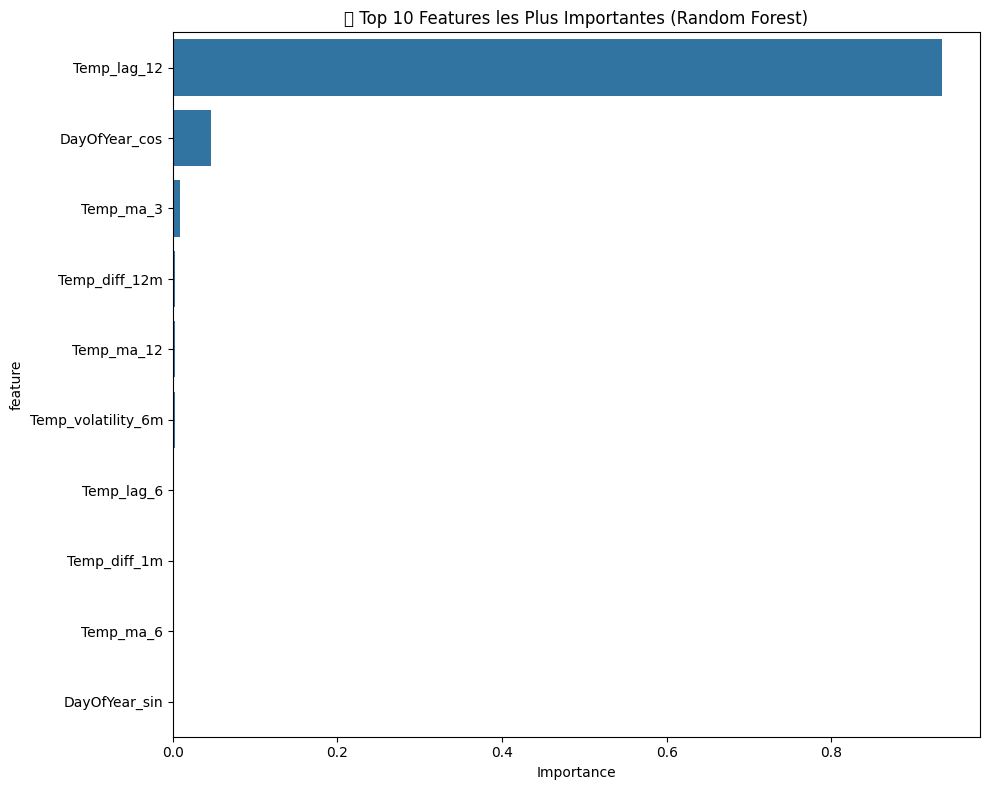


🔍 Top 5 features importantes:
   Temp_lag_12: 0.9337
   DayOfYear_cos: 0.0465
   Temp_ma_3: 0.0082
   Temp_diff_12m: 0.0024
   Temp_ma_12: 0.0023


In [19]:
# Entraînement Random Forest avec MLflow tracking
with mlflow.start_run(run_name="RandomForest_Baseline"):
    print('🌲 ENTRAÎNEMENT RANDOM FOREST...')
    
    # Paramètres du modèle
    rf_params = {
        'n_estimators': 200,
        'max_depth': 15,
        'min_samples_split': 5,
        'min_samples_leaf': 2,
        'random_state': 42
    }
    
    # Log des paramètres
    mlflow.log_params(rf_params)
    
    # Entraînement
    rf_model = RandomForestRegressor(**rf_params)
    rf_model.fit(X_train_scaled, y_train)
    
    # Prédictions
    rf_train_pred = rf_model.predict(X_train_scaled)
    rf_test_pred = rf_model.predict(X_test_scaled)
    
    # Métriques
    train_rmse = np.sqrt(mean_squared_error(y_train, rf_train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, rf_test_pred))
    train_mae = mean_absolute_error(y_train, rf_train_pred)
    test_mae = mean_absolute_error(y_test, rf_test_pred)
    train_r2 = r2_score(y_train, rf_train_pred)
    test_r2 = r2_score(y_test, rf_test_pred)
    
    # Log des métriques
    mlflow.log_metrics({
        'train_rmse': train_rmse,
        'test_rmse': test_rmse,
        'train_mae': train_mae,
        'test_mae': test_mae,
        'train_r2': train_r2,
        'test_r2': test_r2
    })
    
    # Sauvegarde du modèle
    mlflow.sklearn.log_model(rf_model, "random_forest_model")
    
    print(f'📊 RÉSULTATS RANDOM FOREST:')
    print(f'   Train RMSE: {train_rmse:.4f}°C')
    print(f'   Test RMSE: {test_rmse:.4f}°C')
    print(f'   Test R²: {test_r2:.4f}')

# Importance des features
feature_importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(data=feature_importance.head(10), y='feature', x='importance')
plt.title('🔍 Top 10 Features les Plus Importantes (Random Forest)')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()

print(f'\n🔍 Top 5 features importantes:')
for idx, row in feature_importance.head().iterrows():
    print(f'   {row["feature"]}: {row["importance"]:.4f}')

## 📈 MODÈLE 2: ARIMA (SÉRIE TEMPORELLE)

In [20]:
# Préparation des données pour ARIMA (série temporelle pure)
with mlflow.start_run(run_name="ARIMA_TimesSeries"):
    print('📈 ENTRAÎNEMENT MODÈLE ARIMA...')
    
    # Données mensuelles pour ARIMA
    monthly_data = df_features.groupby(['Year', 'Month'])['LandAverageTemperature'].mean().reset_index()
    monthly_data['date'] = pd.to_datetime(monthly_data[['Year', 'Month']].assign(day=1))
    monthly_data = monthly_data.sort_values('date').set_index('date')
    
    # Division train/test
    train_size = int(len(monthly_data) * 0.8)
    train_ts = monthly_data['LandAverageTemperature'][:train_size]
    test_ts = monthly_data['LandAverageTemperature'][train_size:]
    
    print(f'📊 Série temporelle: {len(monthly_data)} points mensuels')
    print(f'🚂 Train: {len(train_ts)} mois')
    print(f'🧪 Test: {len(test_ts)} mois')
    
    # Paramètres ARIMA (p, d, q)
    arima_order = (2, 1, 2)  # Auto-régression, différenciation, moyenne mobile
    seasonal_order = (1, 1, 1, 12)  # Saisonnalité annuelle
    
    mlflow.log_param('arima_order', str(arima_order))
    mlflow.log_param('seasonal_order', str(seasonal_order))
    
    try:
        # Entraînement ARIMA
        from statsmodels.tsa.statespace.sarimax import SARIMAX
        
        arima_model = SARIMAX(train_ts, 
                             order=arima_order,
                             seasonal_order=seasonal_order,
                             enforce_stationarity=False,
                             enforce_invertibility=False)
        
        arima_fitted = arima_model.fit(disp=False)
        
        # Prédictions
        arima_train_pred = arima_fitted.fittedvalues
        arima_forecast = arima_fitted.forecast(steps=len(test_ts))
        
        # Métriques
        arima_train_rmse = np.sqrt(mean_squared_error(train_ts, arima_train_pred))
        arima_test_rmse = np.sqrt(mean_squared_error(test_ts, arima_forecast))
        arima_test_mae = mean_absolute_error(test_ts, arima_forecast)
        arima_test_r2 = r2_score(test_ts, arima_forecast)
        
        # Log des métriques
        mlflow.log_metrics({
            'train_rmse': arima_train_rmse,
            'test_rmse': arima_test_rmse,
            'test_mae': arima_test_mae,
            'test_r2': arima_test_r2,
            'aic': arima_fitted.aic,
            'bic': arima_fitted.bic
        })
        
        print(f'📊 RÉSULTATS ARIMA:')
        print(f'   Train RMSE: {arima_train_rmse:.4f}°C')
        print(f'   Test RMSE: {arima_test_rmse:.4f}°C')
        print(f'   Test R²: {arima_test_r2:.4f}')
        print(f'   AIC: {arima_fitted.aic:.2f}')
        
    except Exception as e:
        print(f'❌ Erreur ARIMA: {str(e)}')
        mlflow.log_param('error', str(e))

📈 ENTRAÎNEMENT MODÈLE ARIMA...
📊 Série temporelle: 1992 points mensuels
🚂 Train: 1593 mois
🧪 Test: 399 mois
📊 RÉSULTATS ARIMA:
   Train RMSE: 0.4169°C
   Test RMSE: 0.4643°C
   Test R²: 0.9874
   AIC: 1081.56


## 🧠 MODÈLE 3: LSTM (DEEP LEARNING)

In [21]:
def create_sequences(data, seq_length):
    """Création de séquences pour LSTM"""
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:(i + seq_length)])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

with mlflow.start_run(run_name="LSTM_DeepLearning"):
    print('🧠 ENTRAÎNEMENT MODÈLE LSTM...')
    
    # Préparation des données séquentielles
    sequence_length = 12  # 12 mois de contexte
    
    # Utilisation de la série temporelle mensuelle
    temp_values = monthly_data['LandAverageTemperature'].values
    
    # Normalisation pour LSTM
    temp_scaler = StandardScaler()
    temp_scaled = temp_scaler.fit_transform(temp_values.reshape(-1, 1)).flatten()
    
    # Création des séquences
    X_seq, y_seq = create_sequences(temp_scaled, sequence_length)
    
    # Division train/test
    train_size_seq = int(len(X_seq) * 0.8)
    X_train_seq, X_test_seq = X_seq[:train_size_seq], X_seq[train_size_seq:]
    y_train_seq, y_test_seq = y_seq[:train_size_seq], y_seq[train_size_seq:]
    
    # Reshape pour LSTM (samples, timesteps, features)
    X_train_seq = X_train_seq.reshape((X_train_seq.shape[0], X_train_seq.shape[1], 1))
    X_test_seq = X_test_seq.reshape((X_test_seq.shape[0], X_test_seq.shape[1], 1))
    
    print(f'📊 Séquences LSTM: {X_train_seq.shape}')
    
    # Paramètres du modèle
    lstm_params = {
        'sequence_length': sequence_length,
        'lstm_units': 50,
        'dropout': 0.2,
        'epochs': 50,
        'batch_size': 32,
        'learning_rate': 0.001
    }
    
    mlflow.log_params(lstm_params)
    
    # Construction du modèle LSTM
    lstm_model = Sequential([
        LSTM(lstm_params['lstm_units'], return_sequences=True, input_shape=(sequence_length, 1)),
        Dropout(lstm_params['dropout']),
        LSTM(lstm_params['lstm_units']),
        Dropout(lstm_params['dropout']),
        Dense(25),
        Dense(1)
    ])
    
    lstm_model.compile(optimizer=Adam(learning_rate=lstm_params['learning_rate']), 
                      loss='mse',
                      metrics=['mae'])
    
    # Entraînement
    history = lstm_model.fit(
        X_train_seq, y_train_seq,
        epochs=lstm_params['epochs'],
        batch_size=lstm_params['batch_size'],
        validation_split=0.2,
        verbose=0
    )
    
    # Prédictions
    lstm_train_pred = lstm_model.predict(X_train_seq, verbose=0)
    lstm_test_pred = lstm_model.predict(X_test_seq, verbose=0)
    
    # Dénormalisation
    lstm_train_pred = temp_scaler.inverse_transform(lstm_train_pred).flatten()
    lstm_test_pred = temp_scaler.inverse_transform(lstm_test_pred).flatten()
    y_train_actual = temp_scaler.inverse_transform(y_train_seq.reshape(-1, 1)).flatten()
    y_test_actual = temp_scaler.inverse_transform(y_test_seq.reshape(-1, 1)).flatten()
    
    # Métriques
    lstm_train_rmse = np.sqrt(mean_squared_error(y_train_actual, lstm_train_pred))
    lstm_test_rmse = np.sqrt(mean_squared_error(y_test_actual, lstm_test_pred))
    lstm_test_mae = mean_absolute_error(y_test_actual, lstm_test_pred)
    lstm_test_r2 = r2_score(y_test_actual, lstm_test_pred)
    
    # Log des métriques
    mlflow.log_metrics({
        'train_rmse': lstm_train_rmse,
        'test_rmse': lstm_test_rmse,
        'test_mae': lstm_test_mae,
        'test_r2': lstm_test_r2,
        'final_loss': history.history['loss'][-1],
        'final_val_loss': history.history['val_loss'][-1]
    })
    
    # Sauvegarde du modèle
    mlflow.tensorflow.log_model(lstm_model, "lstm_model")
    
    print(f'📊 RÉSULTATS LSTM:')
    print(f'   Train RMSE: {lstm_train_rmse:.4f}°C')
    print(f'   Test RMSE: {lstm_test_rmse:.4f}°C')
    print(f'   Test R²: {lstm_test_r2:.4f}')

🧠 ENTRAÎNEMENT MODÈLE LSTM...
📊 Séquences LSTM: (1584, 12, 1)


2025/12/02 23:04:26 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/12/02 23:04:26 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.
2025/12/02 23:04:34 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


📊 RÉSULTATS LSTM:
   Train RMSE: 0.4258°C
   Test RMSE: 0.5663°C
   Test R²: 0.9812


## 📊 COMPARAISON DES MODÈLES

🏆 COMPARAISON DES MODÈLES:
       Modèle  Test RMSE (°C)  Test MAE (°C)  Test R²          Type
Random Forest        0.190044       0.146929 0.997932      Ensemble
         LSTM        0.566277       0.456023 0.981243 Deep Learning


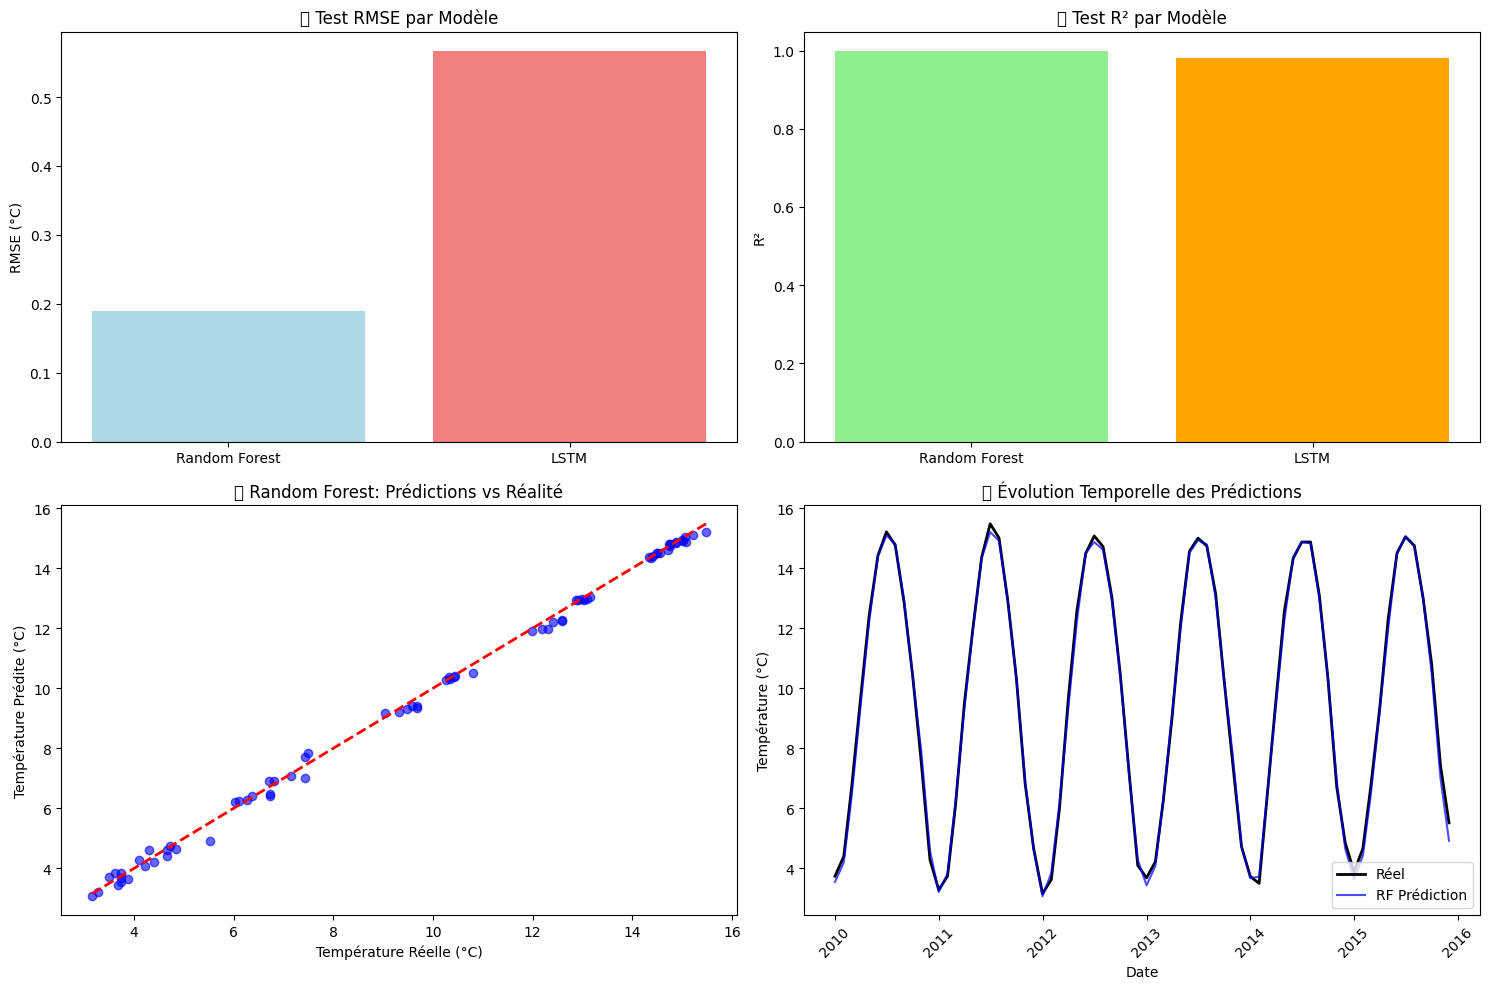


🏆 MEILLEUR MODÈLE: Random Forest
   RMSE: 0.1900°C
   R²: 0.9979

✅ DÉVELOPPEMENT DES MODÈLES TERMINÉ!
📊 Consultez MLflow sur http://localhost:5050 pour voir tous les détails des expériences


In [22]:
# Résumé de la comparaison des modèles
models_comparison = pd.DataFrame({
    'Modèle': ['Random Forest', 'LSTM'],
    'Test RMSE (°C)': [test_rmse, lstm_test_rmse],
    'Test MAE (°C)': [test_mae, lstm_test_mae],
    'Test R²': [test_r2, lstm_test_r2],
    'Type': ['Ensemble', 'Deep Learning']
})

print('🏆 COMPARAISON DES MODÈLES:')
print('=' * 50)
print(models_comparison.to_string(index=False))

# Graphique de comparaison
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# RMSE Comparison
axes[0,0].bar(models_comparison['Modèle'], models_comparison['Test RMSE (°C)'], 
             color=['lightblue', 'lightcoral'])
axes[0,0].set_title('🎯 Test RMSE par Modèle')
axes[0,0].set_ylabel('RMSE (°C)')

# R² Comparison
axes[0,1].bar(models_comparison['Modèle'], models_comparison['Test R²'], 
             color=['lightgreen', 'orange'])
axes[0,1].set_title('📈 Test R² par Modèle')
axes[0,1].set_ylabel('R²')

# Prédictions vs Réalité (Random Forest)
axes[1,0].scatter(y_test[:100], rf_test_pred[:100], alpha=0.6, color='blue')
axes[1,0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[1,0].set_xlabel('Température Réelle (°C)')
axes[1,0].set_ylabel('Température Prédite (°C)')
axes[1,0].set_title('🌲 Random Forest: Prédictions vs Réalité')

# Évolution temporelle des prédictions
test_dates = test_data['dt'].iloc[:100]
axes[1,1].plot(test_dates, y_test.iloc[:100], label='Réel', color='black', linewidth=2)
axes[1,1].plot(test_dates, rf_test_pred[:100], label='RF Prédiction', 
              color='blue', alpha=0.7)
axes[1,1].set_xlabel('Date')
axes[1,1].set_ylabel('Température (°C)')
axes[1,1].set_title('📅 Évolution Temporelle des Prédictions')
axes[1,1].legend()
axes[1,1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Identification du meilleur modèle
best_model_idx = models_comparison['Test RMSE (°C)'].idxmin()
best_model = models_comparison.iloc[best_model_idx]

print(f'\n🏆 MEILLEUR MODÈLE: {best_model["Modèle"]}')
print(f'   RMSE: {best_model["Test RMSE (°C)"]:.4f}°C')
print(f'   R²: {best_model["Test R²"]:.4f}')

print('\n✅ DÉVELOPPEMENT DES MODÈLES TERMINÉ!')
print('📊 Consultez MLflow sur http://localhost:5050 pour voir tous les détails des expériences')

## 📊 MÉTRIQUES AVANCÉES DE COMPARAISON

In [ ]:
# Installation des packages supplémentaires pour les métriques
!pip install scikit-learn scipy --quiet

from sklearn.metrics import (
    mean_absolute_percentage_error, median_absolute_error,
    mean_squared_log_error, mean_absolute_error,
    explained_variance_score, mean_squared_error
)
from scipy import stats
import json

# Fonction pour calculer les métriques avancées
def compute_advanced_metrics(y_true, y_pred, model_name):
    """Calcul des métriques avancées pour la comparaison des modèles"""
    
    y_true = np.array(y_true).flatten()
    y_pred = np.array(y_pred).flatten()
    
    # Résidus
    residuals = y_true - y_pred
    
    metrics = {
        'Model': model_name,
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        'MAE': mean_absolute_error(y_true, y_pred),
        'R²': r2_score(y_true, y_pred),
        'MAPE': mean_absolute_percentage_error(y_true, y_pred),
        'Median_AE': median_absolute_error(y_true, y_pred),
        'Explained_Variance': explained_variance_score(y_true, y_pred),
        'Max_Error': np.max(np.abs(residuals)),
        'Min_Error': np.min(np.abs(residuals)),
        'Std_Residuals': np.std(residuals),
        'Skewness_Residuals': stats.skew(residuals),
        'Kurtosis_Residuals': stats.kurtosis(residuals),
        'Mean_Residuals': np.mean(residuals),
        'RMSE_std': np.std(np.abs(residuals))
    }
    
    return metrics

print('📊 CALCUL DES MÉTRIQUES AVANCÉES...')
print('=' * 80)

# Calcul pour tous les modèles
all_metrics = []

# Random Forest
rf_metrics = compute_advanced_metrics(y_test, rf_test_pred, 'Random Forest')
all_metrics.append(rf_metrics)

# LSTM
lstm_metrics = compute_advanced_metrics(y_test_actual, lstm_test_pred, 'LSTM')
all_metrics.append(lstm_metrics)

# ARIMA
if 'arima_test_rmse' in locals():
    arima_metrics = compute_advanced_metrics(test_ts.values, arima_forecast.values, 'ARIMA')
    all_metrics.append(arima_metrics)

# DataFrame avec toutes les métriques
metrics_df = pd.DataFrame(all_metrics)

print('\n🏆 COMPARAISON COMPLÈTE DES MODÈLES:')
print(metrics_df.to_string(index=False))

# Sauvegarder les métriques en JSON
metrics_json = metrics_df.to_json(orient='records', indent=2)
with open('model_metrics_comparison.json', 'w') as f:
    f.write(metrics_json)
print(f'\n✅ Métriques sauvegardées dans: model_metrics_comparison.json')

# Visualisation des métriques avancées
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('📊 COMPARAISON AVANCÉE DES MODÈLES', fontsize=16, fontweight='bold')

# 1. RMSE vs MAE
axes[0, 0].scatter(metrics_df['RMSE'], metrics_df['MAE'], s=200, alpha=0.6, c=['#1f77b4', '#ff7f0e', '#2ca02c'])
for i, model in enumerate(metrics_df['Model']):
    axes[0, 0].annotate(model, (metrics_df['RMSE'].iloc[i], metrics_df['MAE'].iloc[i]), xytext=(5, 5), textcoords='offset points')
axes[0, 0].set_xlabel('RMSE (°C)')
axes[0, 0].set_ylabel('MAE (°C)')
axes[0, 0].set_title('RMSE vs MAE')
axes[0, 0].grid(True, alpha=0.3)

# 2. R² vs MAPE
axes[0, 1].barh(metrics_df['Model'], metrics_df['R²'], color=['#1f77b4', '#ff7f0e', '#2ca02c'][:len(metrics_df)])
axes[0, 1].set_xlabel('R² Score')
axes[0, 1].set_title('R² Score par Modèle')
axes[0, 1].set_xlim([0.97, 1.0])

# 3. MAPE Comparison
axes[0, 2].barh(metrics_df['Model'], metrics_df['MAPE'], color=['#1f77b4', '#ff7f0e', '#2ca02c'][:len(metrics_df)])
axes[0, 2].set_xlabel('MAPE (%)')
axes[0, 2].set_title('MAPE (Mean Absolute Percentage Error)')

# 4. Résidus - Distribution
for idx, row in metrics_df.iterrows():
    if row['Model'] == 'Random Forest':
        residuals_rf = y_test.values - rf_test_pred
        axes[1, 0].hist(residuals_rf, bins=50, alpha=0.7, label=row['Model'])
    elif row['Model'] == 'LSTM':
        residuals_lstm = y_test_actual - lstm_test_pred
        axes[1, 0].hist(residuals_lstm, bins=50, alpha=0.7, label=row['Model'])
axes[1, 0].set_xlabel('Résidus (°C)')
axes[1, 0].set_ylabel('Fréquence')
axes[1, 0].set_title('Distribution des Résidus')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 5. Erreur Max vs Min
x_pos = np.arange(len(metrics_df))
width = 0.35
axes[1, 1].bar(x_pos - width/2, metrics_df['Max_Error'], width, label='Max Error', alpha=0.8)
axes[1, 1].bar(x_pos + width/2, metrics_df['Min_Error'], width, label='Min Error', alpha=0.8)
axes[1, 1].set_xlabel('Modèle')
axes[1, 1].set_ylabel('Erreur (°C)')
axes[1, 1].set_title('Erreur Max vs Min')
axes[1, 1].set_xticks(x_pos)
axes[1, 1].set_xticklabels(metrics_df['Model'])
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3, axis='y')

# 6. Explained Variance
axes[1, 2].barh(metrics_df['Model'], metrics_df['Explained_Variance'], color=['#1f77b4', '#ff7f0e', '#2ca02c'][:len(metrics_df)])
axes[1, 2].set_xlabel('Variance Expliquée')
axes[1, 2].set_title('Variance Expliquée par Modèle')

plt.tight_layout()
plt.savefig('advanced_metrics_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print('\n✅ Graphique sauvegardé: advanced_metrics_comparison.png')

## 🚀 PROCHAINES ÉTAPES

### Modèles développés avec succès:
1. **Random Forest** - Modèle d'ensemble robuste
2. **LSTM** - Réseau de neurones pour séries temporelles

### Prochaines étapes recommandées:
1. **Optimisation des hyperparamètres** avec Optuna
2. **Création d'une API FastAPI** pour servir le meilleur modèle
3. **Pipeline de données automatisé** pour l'entraînement continu
4. **Monitoring de la dérive des données** en production
5. **Tests unitaires et d'intégration**

### Métriques trackées dans MLflow:
- RMSE (Root Mean Square Error)
- MAE (Mean Absolute Error)  
- R² (Coefficient de détermination)
- Paramètres des modèles
- Artifacts (modèles sauvegardés)